In [2]:
from nbed.driver import NbedDriver
from nbed.ham_builder import HamiltonianBuilder
from openfermion import get_sparse_operator
import scipy as sp
from openfermion.utils import count_qubits
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
from nbed.mol_plot import Draw_molecule
import pandas as pd

/Users/lex/anaconda3/envs/Embed/lib/python3.7/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In [43]:
current_dir = os.getcwd()
structure_dir =  os.path.join(current_dir, "molecular_structures")

In [44]:
# order by R_length

list_files = [ filename for filename in os.listdir(structure_dir) if filename.startswith('act_stretch_H2O')]

all_xyz_files = sorted(list_files, 
                       key=lambda text: int(text.partition("H2O_")[2].partition(".xyz")[0]))
all_xyz_files

['act_stretch_H2O_40.xyz',
 'act_stretch_H2O_60.xyz',
 'act_stretch_H2O_79.xyz',
 'act_stretch_H2O_100.xyz',
 'act_stretch_H2O_120.xyz',
 'act_stretch_H2O_150.xyz',
 'act_stretch_H2O_200.xyz',
 'act_stretch_H2O_300.xyz',
 'act_stretch_H2O_400.xyz',
 'act_stretch_H2O_500.xyz']

In [45]:
list_file_paths = []
for xyz_filename in all_xyz_files:
    list_file_paths.append(os.path.join(structure_dir, xyz_filename))
list_file_paths

['/Users/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/act_stretch_H2O_40.xyz',
 '/Users/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/act_stretch_H2O_60.xyz',
 '/Users/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/act_stretch_H2O_79.xyz',
 '/Users/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/act_stretch_H2O_100.xyz',
 '/Users/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/act_stretch_H2O_120.xyz',
 '/Users/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/act_stretch_H2O_150.xyz',
 '/Users/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/act_stretch_H2O_200.xyz',
 '/Users/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/act_stretch_H2O_300.xyz',
 '/Users/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/act_stretch_H2O_400.xyz',
 '/Users/lex/Documents/PhD/Nbed/projects/water_correlated/

In [54]:
with open(list_file_paths[0], 'r') as infile1:
    test_xyz = infile1.read()
    
print(test_xyz)

3
 
H	0.3751747	0.0	0.1387225
O	0.0	0.0	0.0
H	-0.7493682	0.0	0.2770822



In [6]:
basis = 'STO-3G'
xc_functional = 'B3LYP'
convergence = 1e-6
charge = 0
mu_level_shift=1e6
run_ccsd_emb = True
run_fci_emb = True
max_ram_memory = 8_000
pyscf_print_level = 1
unit = 'angstrom'


occupied_threshold = 0.95
virtual_threshold = 0.95
max_hf_cycles=10_000
max_dft_cycles = 100_000
transform = 'jordan_wigner'

In [6]:
n_active_atoms = 2
localization = 'spade' #ibo, spade

projector = 'both' #'both', 'huzinaga'
init_huzinaga_rhf_with_mu = True

In [7]:
def get_hamiltonian_from_driver(rhf_pyscf, energy_shift, qubit_transform):
    # n_qubits = 2*rhf_pyscf.mol.nao
    qham = HamiltonianBuilder(
                            scf_method=rhf_pyscf,
                            constant_e_shift=energy_shift,
                            transform=qubit_transform,
                            ).build(n_qubits=None, taper=False)
    return qham

In [9]:
global_dft_list=[]
global_fci_list=[]
global_H_diag_list=[]
global_qubit_H_length_list=[]
global_qubit_H_nqubits=[]

huz_rhf_list=[]
huz_ccsd_list=[]
huz_fci_list=[]
huz_H_diag_list=[]
huz_qubit_H_length_list=[]
huz_H_nqubits=[]

mu_rhf_list=[]
mu_ccsd_list=[]
mu_fci_list=[]
mu_H_diag_list=[]
mu_qubit_H_length_list=[]
mu_H_nqubits=[]
N_active_MOs=[]

for geometry_path in tqdm(list_file_paths):
#     try:
    driver = NbedDriver(
            geometry=geometry_path,
            n_active_atoms=n_active_atoms,
            basis=basis,
            xc_functional=xc_functional,
            projector=projector,
            localization=localization,
            convergence=convergence,
            charge=charge,
            mu_level_shift=mu_level_shift,
            run_ccsd_emb=run_ccsd_emb,
            run_fci_emb=run_fci_emb,
            max_ram_memory=max_ram_memory,
            pyscf_print_level=pyscf_print_level,
            unit=unit,
            occupied_threshold=occupied_threshold,
            virtual_threshold=virtual_threshold,
            max_hf_cycles=max_hf_cycles,
            max_dft_cycles=max_dft_cycles,
            _init_huzinaga_rhf_with_mu = init_huzinaga_rhf_with_mu)
#     except:
#         print('error for:')
#         print(geometry_path)
#         print()
#         continue

    ## global
    global_dft_list.append(driver._global_rks.e_tot)
    global_fci_list.append(driver._global_fci.e_tot)
    
    global_qubit_Ham = get_hamiltonian_from_driver(driver._global_hf,
                                           driver._global_hf.energy_nuc(), 
                                           transform)
    
    global_H_sparse = get_sparse_operator(global_qubit_Ham)
    E_fci =  sp.sparse.linalg.eigsh(global_H_sparse, k=1, which='SA')[0][0] 
    global_H_diag_list.append(E_fci)

    global_qubit_H_length_list.append(len(global_qubit_Ham.terms))
    global_qubit_H_nqubits.append(count_qubits(global_qubit_Ham))

    ##
    N_active_MOs.append(len(driver.localized_system.active_MO_inds))
    
    # HUZ
    huz_rhf_list.append(driver._huzinaga['e_rhf'])
    huz_ccsd_list.append(driver._huzinaga['e_ccsd'])
    huz_fci_list.append(driver._huzinaga['e_fci'])

    huz_classical = driver._huzinaga['classical_energy']
    huz_qubit_Ham = get_hamiltonian_from_driver(driver._huzinaga["scf"],
                                        huz_classical, #+ driver._huzinaga["scf"].energy_nuc(), 
                                        transform)
    
    huz_H_sparse = get_sparse_operator(huz_qubit_Ham)
    huz_e_emb = sp.sparse.linalg.eigsh(huz_H_sparse, k=1, which='SA')[0][0]
    huz_H_diag_list.append(huz_e_emb)

    huz_qubit_H_length_list.append(len(huz_qubit_Ham.terms))
    huz_nqubits = count_qubits(huz_qubit_Ham)
    huz_H_nqubits.append(huz_nqubits)

    # mu shift
    mu_rhf_list.append(driver._mu['e_rhf'])
    mu_ccsd_list.append(driver._mu['e_ccsd'])
    mu_fci_list.append(driver._mu['e_fci'])
    
    mu_classical = driver._mu['classical_energy']
    mu_qubit_Ham = get_hamiltonian_from_driver(driver._mu["scf"],
                                        mu_classical, #+ driver._mu["scf"].energy_nuc(), 
                                        transform)
    
    mu_H_sparse = get_sparse_operator(mu_qubit_Ham)
    mu_e_emb = sp.sparse.linalg.eigsh(mu_H_sparse, k=1, which='SA')[0][0]
    mu_H_diag_list.append(mu_e_emb)
    
    mu_nqubits = count_qubits(huz_qubit_Ham)
    mu_qubit_H_length_list.append(len(mu_qubit_Ham.terms))
    mu_H_nqubits.append(mu_nqubits)
    
    del driver



  0%|          | 0/10 [00:00<?, ?it/s]

In [19]:
np.allclose(global_fci_list, global_H_diag_list)

True

In [10]:
exp_data = {
    'global DFT': global_dft_list, 
    
    'global FCI': global_fci_list,
    'huz emb FCI': huz_H_diag_list,
    'mu emb FCI': mu_H_diag_list,
    
    'global H': global_qubit_H_length_list,
    'huz H emb': huz_qubit_H_length_list,
    'mu H emb': mu_qubit_H_length_list,
    
    'global n qubits': global_qubit_H_nqubits,
    'huz n qubits': huz_H_nqubits,
    'mu n qubits': mu_H_nqubits,
    'N active MOs': N_active_MOs,
    
}

df = pd.DataFrame(data=exp_data)

df

,global DFT,global FCI,huz emb FCI,mu emb FCI,global H,huz H emb,mu H emb,global n qubits,huz n qubits,mu n qubits,N active MOs
0,-73.259936,-72.981056,-72.988008,-72.988009,2110,1079,1079,14,12,12,4
1,-74.773419,-74.499220,-74.508545,-74.508545,2110,1079,1079,14,12,12,4
2,-75.122053,-74.851089,-74.864002,-74.864002,1086,1079,1079,14,12,12,4
3,-75.170068,-74.900658,-74.918225,-74.918226,2110,1079,1079,14,12,12,4
4,-75.134418,-74.867498,-74.890912,-74.890913,2110,1079,1079,14,12,12,4
5,-75.057384,-74.807539,-74.840739,-74.840739,2110,1079,1079,14,12,12,4
6,-74.962535,-74.776263,-74.816902,-74.816902,2110,1079,1079,14,12,12,4
7,-74.890579,-74.771692,-74.820213,-74.820213,2342,1543,1551,14,12,12,4
8,-74.874152,-74.771719,-74.820244,-74.820244,2526,1819,1819,14,12,12,4
9,-74.872382,-74.771718,-74.820270,-74.820271,3054,1795,1795,14,12,12,4


In [11]:
csv_filename = 'active_OH_stretch_results_SPADE.csv' 
df.to_csv(os.path.join(current_dir, csv_filename), index=False)

In [7]:
# import results
csv_filename = 'active_OH_stretch_results_SPADE.csv' 
df = pd.read_csv(os.path.join(current_dir, csv_filename))

global_dft_list = np.array(df['global DFT'])

global_fci_list = np.array(df['global FCI'])
huz_H_diag_list = np.array(df['huz emb FCI'])
mu_H_diag_list = np.array(df['mu emb FCI'])

global_qubit_H_length_list = np.array(df['global H'])
huz_qubit_H_length_list = np.array(df['huz H emb'])
mu_qubit_H_length_list = np.array(df['mu H emb'])

global_qubit_H_nqubits = np.array(df['global n qubits'])
huz_H_nqubits = np.array(df['huz n qubits'])
mu_H_nqubits = np.array(df['mu n qubits'])
N_active_MOs = np.array(df['N active MOs'])



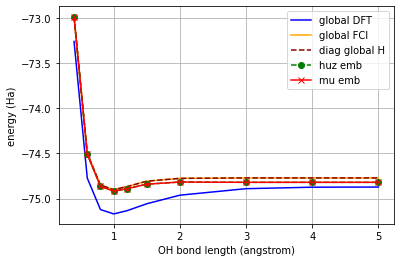

In [12]:
%matplotlib inline

R_list =  [0.4, 0.6, 0.7989538439284714, 1, 1.2, 1.5, 2, 3, 4, 5]


plt.plot(R_list, global_dft_list, label='global DFT', color='b')
plt.plot(R_list, global_fci_list, label='global FCI', color='orange')
plt.plot(R_list, global_fci_list, label='diag global H', linestyle='dashed', color='darkred')
plt.plot(R_list, huz_H_diag_list, label='huz emb', linestyle='dashed', marker='o', color='g')
plt.plot(R_list, mu_H_diag_list, label='mu emb', linestyle='-', marker='x', color='r')

plt.xlabel('OH bond length (angstrom)')
plt.ylabel('energy (Ha)')
plt.grid(True)
plt.legend()
plt.savefig("test_energy.png", dpi=300)
plt.show()

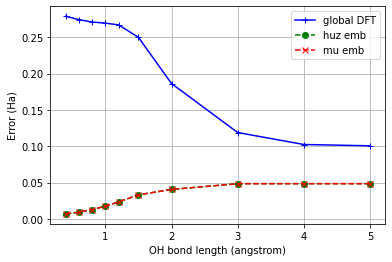

In [13]:
%matplotlib inline

R_list =  [0.4, 0.6, 0.7989538439284714, 1, 1.2, 1.5, 2, 3, 4, 5]


plt.plot(R_list, abs(np.array(global_dft_list) - np.array(global_fci_list)), label='global DFT', color='b', marker='+')
plt.plot(R_list, abs(np.array(huz_H_diag_list) - np.array(global_fci_list)), label='huz emb', linestyle='dashed', marker='o', color='g')
plt.plot(R_list, abs(np.array(mu_H_diag_list) - np.array(global_fci_list)), label='mu emb', linestyle='--', marker='x', color='r')

plt.xlabel('OH bond length (angstrom)')
plt.ylabel('Error (Ha)')
plt.grid(True)
plt.legend()
plt.savefig("test_error.png", dpi=300)
plt.show()

In [46]:
# order by R_length

list_files_nonstretch = [ filename for filename in os.listdir(structure_dir) if filename.startswith('act_nonstretch_H2O')]

all_xyz_files_nonstretch = sorted(list_files_nonstretch, 
                       key=lambda text: int(text.partition("H2O_")[2].partition(".xyz")[0]))


list_file_paths_nonstretch = []
for xyz_filename in all_xyz_files_nonstretch:
    list_file_paths_nonstretch.append(os.path.join(structure_dir, xyz_filename))
list_file_paths_nonstretch

['/Users/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/act_nonstretch_H2O_4.xyz',
 '/Users/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/act_nonstretch_H2O_6.xyz',
 '/Users/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/act_nonstretch_H2O_7.xyz',
 '/Users/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/act_nonstretch_H2O_10.xyz',
 '/Users/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/act_nonstretch_H2O_12.xyz',
 '/Users/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/act_nonstretch_H2O_15.xyz',
 '/Users/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/act_nonstretch_H2O_20.xyz',
 '/Users/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/act_nonstretch_H2O_30.xyz',
 '/Users/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/act_nonstretch_H2O_40.xyz',
 '/Users/lex/Documents/PhD/Nbed/projects

In [24]:
global_dft_list2=[]
global_fci_list2=[]
global_H_diag_list2=[]
global_qubit_H_length_list2=[]
global_qubit_H_nqubits2=[]

huz_rhf_list2=[]
huz_ccsd_list2=[]
huz_fci_list2=[]
huz_H_diag_list2=[]
huz_qubit_H_length_list2=[]
huz_H_nqubits2=[]

mu_rhf_list2=[]
mu_ccsd_list2=[]
mu_fci_list2=[]
mu_H_diag_list2=[]
mu_qubit_H_length_list2=[]
mu_H_nqubits2=[]
N_active_MOs2 = []


for geometry_path in tqdm(list_file_paths_nonstretch):

    driver = NbedDriver(
            geometry=geometry_path,
            n_active_atoms=n_active_atoms,
            basis=basis,
            xc_functional=xc_functional,
            projector=projector,
            localization=localization,
            convergence=convergence,
            charge=charge,
            mu_level_shift=mu_level_shift,
            run_ccsd_emb=run_ccsd_emb,
            run_fci_emb=run_fci_emb,
            max_ram_memory=max_ram_memory,
            pyscf_print_level=pyscf_print_level,
            unit=unit,
            occupied_threshold=occupied_threshold,
            virtual_threshold=virtual_threshold,
            max_hf_cycles=max_hf_cycles,
            max_dft_cycles=max_dft_cycles,
            _init_huzinaga_rhf_with_mu = init_huzinaga_rhf_with_mu)


    ## global
    global_dft_list2.append(driver._global_rks.e_tot)
    global_fci_list2.append(driver._global_fci.e_tot)
    
    global_qubit_Ham = get_hamiltonian_from_driver(driver._global_hf,
                                           driver._global_hf.energy_nuc(), 
                                           transform)
    
    global_H_sparse = get_sparse_operator(global_qubit_Ham)
    E_fci =  sp.sparse.linalg.eigsh(global_H_sparse, k=1, which='SA')[0][0] 
    global_H_diag_list2.append(E_fci)

    global_qubit_H_length_list2.append(len(global_qubit_Ham.terms))
    global_qubit_H_nqubits2.append(count_qubits(global_qubit_Ham))

    ##
    N_active_MOs2.append(len(driver.localized_system.active_MO_inds))
    
    # HUZ
    huz_rhf_list2.append(driver._huzinaga['e_rhf'])
    huz_ccsd_list2.append(driver._huzinaga['e_ccsd'])
    huz_fci_list2.append(driver._huzinaga['e_fci'])

    huz_classical = driver._huzinaga['classical_energy']
    huz_qubit_Ham = get_hamiltonian_from_driver(driver._huzinaga["scf"],
                                        huz_classical, #+ driver._huzinaga["scf"].energy_nuc(), 
                                        transform)
    
    huz_H_sparse = get_sparse_operator(huz_qubit_Ham)
    huz_e_emb = sp.sparse.linalg.eigsh(huz_H_sparse, k=1, which='SA')[0][0]
    huz_H_diag_list2.append(huz_e_emb)

    huz_qubit_H_length_list2.append(len(huz_qubit_Ham.terms))
    huz_nqubits = count_qubits(huz_qubit_Ham)
    huz_H_nqubits2.append(huz_nqubits)

    # mu shift
    mu_rhf_list2.append(driver._mu['e_rhf'])
    mu_ccsd_list2.append(driver._mu['e_ccsd'])
    mu_fci_list2.append(driver._mu['e_fci'])
    
    mu_classical = driver._mu['classical_energy']
    mu_qubit_Ham = get_hamiltonian_from_driver(driver._mu["scf"],
                                        mu_classical, #+ driver._mu["scf"].energy_nuc(), 
                                        transform)
    
    mu_H_sparse = get_sparse_operator(mu_qubit_Ham)
    mu_e_emb = sp.sparse.linalg.eigsh(mu_H_sparse, k=1, which='SA')[0][0]
    mu_H_diag_list2.append(mu_e_emb)
    
    mu_nqubits = count_qubits(huz_qubit_Ham)
    mu_qubit_H_length_list2.append(len(mu_qubit_Ham.terms))
    mu_H_nqubits2.append(mu_nqubits)
    
    del driver



  0%|          | 0/10 [00:00<?, ?it/s]

In [25]:
exp_data2 = {
    'global DFT': global_dft_list2, 
    
    'global FCI': global_fci_list2,
    'huz emb FCI': huz_H_diag_list2,
    'mu emb FCI': mu_H_diag_list2,
    
    'global H': global_qubit_H_length_list2,
    'huz H emb': huz_qubit_H_length_list2,
    'mu H emb': mu_qubit_H_length_list2,
    
    'global n qubits ': global_qubit_H_nqubits2,
    'huz n qubits ': huz_H_nqubits2,
    'mu n qubits ': mu_H_nqubits2,
    'N active MOs ': N_active_MOs2,
    
}

df2 = pd.DataFrame(data=exp_data2)

df2

,global DFT,global FCI,huz emb FCI,mu emb FCI,global H,huz H emb,mu H emb,global n qubits,huz n qubits,mu n qubits,N active MOs
0,-73.259936,-72.981056,-72.887822,-72.887827,2110,1079,1079,14,12,12,4
1,-74.773419,-74.499220,-74.473689,-74.473691,2110,1079,1079,14,12,12,4
2,-75.122053,-74.851089,-74.864002,-74.864002,1086,1079,1079,14,12,12,4
3,-75.170068,-74.900658,-74.936101,-74.936101,2110,1079,1079,14,12,12,4
4,-75.134418,-74.867498,-74.914336,-74.914336,2110,1079,1079,14,12,12,4
5,-75.057384,-74.807539,-74.847328,-74.847328,2110,1079,1079,14,12,12,4
6,-74.962535,-74.776263,-74.755506,-74.755506,2110,1079,1079,14,12,12,4
7,-74.890579,-74.771692,-74.683925,-74.683925,2210,1079,1083,14,12,12,4
8,-74.873513,-74.771719,-74.672636,-74.672636,2294,1655,1663,14,12,12,4
9,-74.872382,-74.771718,-74.665626,-74.665626,3054,1783,1799,14,12,12,4


In [8]:
csv_filename2 = 'nonactive_OH_stretch_results_SPADE.csv' 
df2.to_csv(os.path.join(current_dir, csv_filename2), index=False)

NameError: name 'df2' is not defined

In [19]:
# import results
csv_filename2 = 'nonactive_OH_stretch_results_SPADE.csv'
df2 = pd.read_csv(os.path.join(current_dir, csv_filename2))

global_dft_list2 = np.array(df2['global DFT'])

global_fci_list2 = np.array(df2['global FCI'])
huz_H_diag_list2 = np.array(df2['huz emb FCI'])
mu_H_diag_list2 = np.array(df2['mu emb FCI'])

global_qubit_H_length_list2 = np.array(df2['global H'])
huz_qubit_H_length_list2 = np.array(df2['huz H emb'])
mu_qubit_H_length_list2 = np.array(df2['mu H emb'])

global_qubit_H_nqubits2 = np.array(df2['global n qubits '])
huz_H_nqubits2 = np.array(df2['huz n qubits '])
mu_H_nqubits2 = np.array(df2['mu n qubits '])
N_active_MOs2 = np.array(df2['N active MOs '])


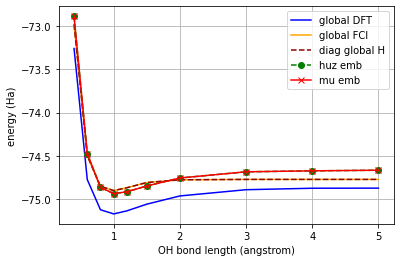

In [20]:
%matplotlib inline

R_list = [0.4, 0.6, 0.7989538439284714, 1, 1.2, 1.5, 2, 3, 4, 5]


plt.plot(R_list, global_dft_list2, label='global DFT', color='b')
plt.plot(R_list, global_fci_list2, label='global FCI', color='orange')
plt.plot(R_list, global_fci_list2, label='diag global H', linestyle='dashed', color='darkred')
plt.plot(R_list, huz_H_diag_list2, label='huz emb', linestyle='dashed', marker='o', color='g')
plt.plot(R_list, mu_H_diag_list2, label='mu emb', linestyle='-', marker='x', color='r')

plt.xlabel('OH bond length (angstrom)')
plt.ylabel('energy (Ha)')
plt.grid(True)
plt.legend()
plt.savefig("test_energy2.png", dpi=300)
plt.show()

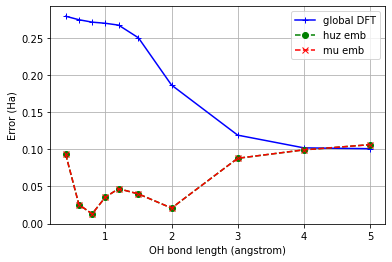

In [21]:
%matplotlib inline

R_list = [0.4, 0.6, 0.7989538439284714, 1, 1.2, 1.5, 2, 3, 4, 5]


plt.plot(R_list, abs(np.array(global_dft_list2) - np.array(global_fci_list2)), label='global DFT', color='b', marker='+')
plt.plot(R_list, abs(np.array(huz_H_diag_list2) - np.array(global_fci_list2)), label='huz emb', linestyle='dashed', marker='o', color='g')
plt.plot(R_list, abs(np.array(mu_H_diag_list2) - np.array(global_fci_list2)), label='mu emb', linestyle='--', marker='x', color='r')

plt.xlabel('OH bond length (angstrom)')
plt.ylabel('Error (Ha)')
plt.grid(True)
plt.legend()
plt.savefig("test_error2.png", dpi=300)
plt.show()

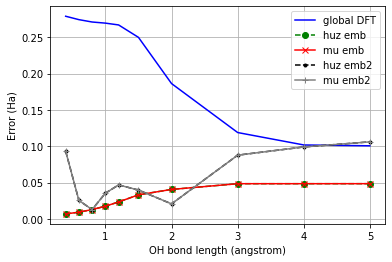

In [29]:
%matplotlib inline

R_list = [0.4, 0.6, 0.7989538439284714, 1, 1.2, 1.5, 2, 3, 4, 5]


plt.plot(R_list, abs(np.array(global_dft_list2) - np.array(global_fci_list)), label='global DFT', color='b')
plt.plot(R_list, abs(np.array(huz_H_diag_list) - np.array(global_fci_list)), label='huz emb', linestyle='dashed', marker='o', color='g')
plt.plot(R_list, abs(np.array(mu_H_diag_list) - np.array(global_fci_list)), label='mu emb', linestyle='-', marker='x', color='r')

plt.plot(R_list, abs(np.array(huz_H_diag_list2) - np.array(global_fci_list2)), label='huz emb2', linestyle='dashed', marker='.', color='k')
plt.plot(R_list, abs(np.array(mu_H_diag_list2) - np.array(global_fci_list2)), label='mu emb2', linestyle='-', marker='+', color='grey')


plt.xlabel('OH bond length (angstrom)')
plt.ylabel('Error (Ha)')
plt.grid(True)
plt.legend()
# plt.savefig("test_error.png", dpi=300)
plt.show()

In [49]:
with open(list_file_paths_nonstretch[0], 'r') as infile1:
    first_xyz = infile1.read()
    
with open(list_file_paths_nonstretch[-2], 'r') as infile2:
    last_xyz = infile2.read()
    
print(first_xyz)
print()
print()
print(last_xyz)

3
 
H	-0.7493682	0.0	0.2770822
O	0.0	0.0	0.0
H	0.3751747	0.0	0.1387225



3
 
H	-0.7493682	0.0	0.2770822
O	0.0	0.0	0.0
H	3.7517471	0.0	1.3872251



In [31]:
with open(list_file_paths[0], 'r') as infile1:
    first_xyz = infile1.read()
    
with open(list_file_paths[-2], 'r') as infile2:
    last_xyz = infile2.read()
    
print(first_xyz)
print()
print()
print(last_xyz)

3
 
H	0.3751747	0.0	0.1387225
O	0.0	0.0	0.0
H	-0.7493682	0.0	0.2770822



3
 
H	3.7517471	0.0	1.3872251
O	0.0	0.0	0.0
H	-0.7493682	0.0	0.2770822



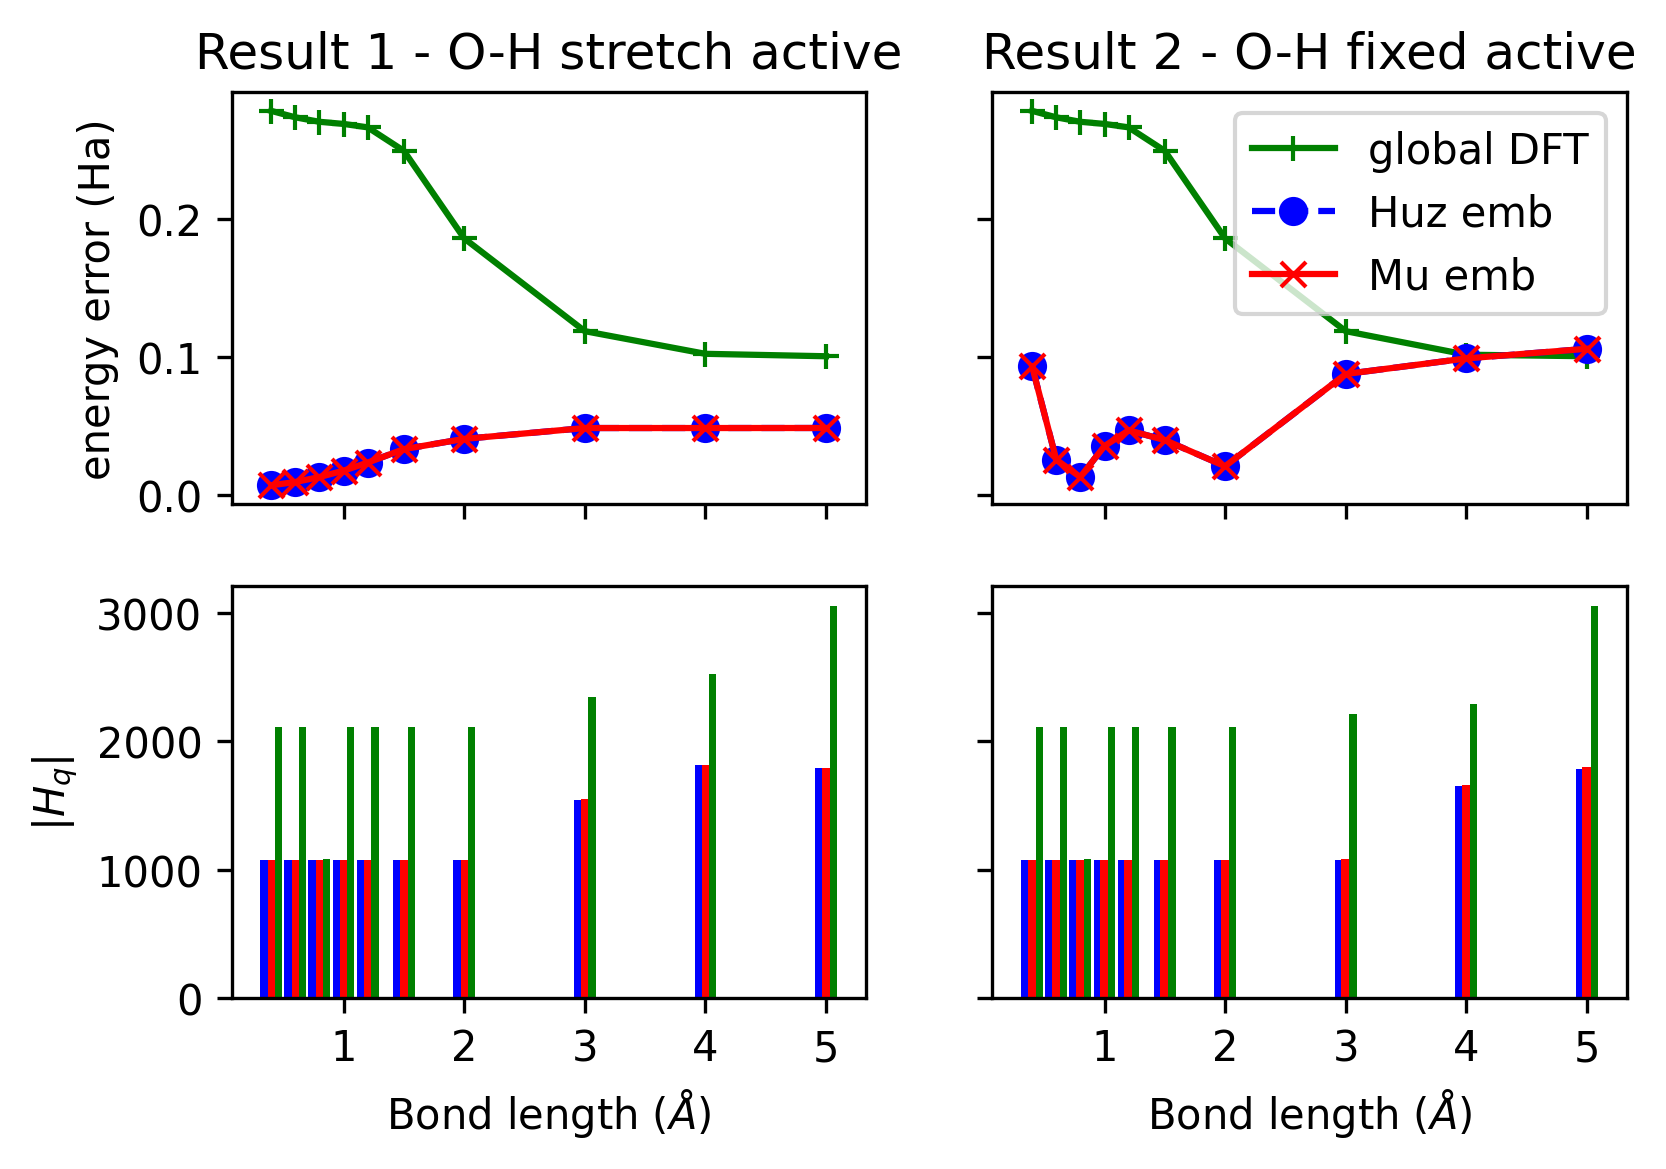

In [32]:
figure, axis = plt.subplots(2, 2, dpi=300, sharex=True)

# 
axis[0, 0].xaxis.set_ticks(range(0,6,1))

# For first result
axis[0, 0].plot(R_list,abs(np.array(global_dft_list) - np.array(global_fci_list)), label='global DFT', color='g', marker='+')
axis[0, 0].plot(R_list,abs(np.array(huz_H_diag_list) - np.array(global_fci_list)), label='huz emb', linestyle='dashed', marker='o', color='b')
axis[0, 0].plot(R_list,abs(np.array(mu_H_diag_list) - np.array(global_fci_list)), label='mu emb', linestyle='-', marker='x', color='r')
axis[0, 0].set_ylabel('energy error (Ha)')
axis[0, 0].set_title("Result 1 - O-H stretch active")
  
# First result - number of terms
axis[1, 0].bar(np.array(R_list)-0.06, huz_qubit_H_length_list, width=0.06, color='b', align='center')
axis[1, 0].bar(R_list, mu_qubit_H_length_list, width=0.06, color='r', align='center')
axis[1, 0].bar(np.array(R_list)+0.06, global_qubit_H_length_list, width=0.06, color='g', align='center')
axis[1, 0].set_ylabel(r'$|H_{q}|$')
axis[1, 0].set_xlabel(r'Bond length ($\AA$)')
# axis[1, 0].set_title("Cosine Function")
  
# # 2nd result
axis[0, 1].plot(R_list,abs(np.array(global_dft_list2) - np.array(global_fci_list2)), label='global DFT', color='g', marker='+')
axis[0, 1].plot(R_list,abs(np.array(huz_H_diag_list2) - np.array(global_fci_list2)), label='Huz emb', linestyle='dashed', marker='o', color='b')
axis[0, 1].plot(R_list,abs(np.array(mu_H_diag_list2) - np.array(global_fci_list2)), label='Mu emb', linestyle='-', marker='x', color='r')
axis[0, 1].set_title("Result 2 - O-H fixed active")
  
# 2nd result - number of terms
axis[1, 1].bar(np.array(R_list)-0.06, huz_qubit_H_length_list2, width=0.06, color='b', align='center')
axis[1, 1].bar(R_list, mu_qubit_H_length_list2, width=0.075, color='r', align='center')
axis[1, 1].bar(np.array(R_list)+0.06, global_qubit_H_length_list2, width=0.06, color='g', align='center')
axis[1, 1].set_xlabel(r'Bond length ($\AA$)')

# shared y axis
axis[0, 0].get_shared_y_axes().join(axis[0, 0], axis[0, 1])
axis[1, 0].get_shared_y_axes().join(axis[1, 0], axis[1, 1])

# remove rightmost y labels
axis[0, 1].set_yticklabels([])
axis[1, 1].set_yticklabels([])

axis[0, 1].legend(loc="upper right")

figure.savefig('water_correlated_results_old.png', dpi=300)

# figure.show()

In [33]:
np.array(global_dft_list2) - np.array(global_dft_list)

array([ 2.84217094e-14, -2.84217094e-14, -1.42108547e-14, -1.42108547e-14,
       -1.42108547e-14, -1.42108547e-14, -1.42108547e-14, -1.61556088e-07,
        6.39197256e-04,  6.12138635e-07])

In [ ]:
# geometry_path  = list_file_paths[3]
# projector = 'both'#'both', 'huzinaga'  

# driver = NbedDriver(
#         geometry=geometry_path,
#         n_active_atoms=n_active_atoms,
#         basis=basis,
#         xc_functional=xc_functional,
#         projector=projector,
#         localization=localization,
#         convergence=convergence,
#         charge=charge,
#         mu_level_shift=mu_level_shift,
#         run_ccsd_emb=run_ccsd_emb,
#         run_fci_emb=run_fci_emb,
#         max_ram_memory=max_ram_memory,
#         pyscf_print_level=pyscf_print_level,
#         unit=unit,
#         occupied_threshold=occupied_threshold,
#         virtual_threshold=virtual_threshold,
#         max_hf_cycles=max_hf_cycles)

In [ ]:
# mu_scf = driver._mu["scf"]
# huz_scf = driver._huzinaga["scf"]
# global_scf = driver._global_hf

In [ ]:
# c_mat = mu_scf.mo_coeff
# mo_occ = mu_scf.get_occ()
# dmat = mu_scf.make_rdm1(mo_coeff=c_mat, mo_occ=mo_occ)
# F =  mu_scf.get_fock(dm=dmat)

# print(np.around(c_mat.T @ F @c_mat,
#          3))

In [ ]:
# c_mat = huz_scf.mo_coeff
# mo_occ = huz_scf.get_occ()
# dmat = huz_scf.make_rdm1(mo_coeff=c_mat, mo_occ=mo_occ)
# F =  huz_scf.get_fock(dm=dmat)

# print(np.around(c_mat.T @ F @c_mat,
#          3))

Text(0, 0.5, 'energy error (Ha)')

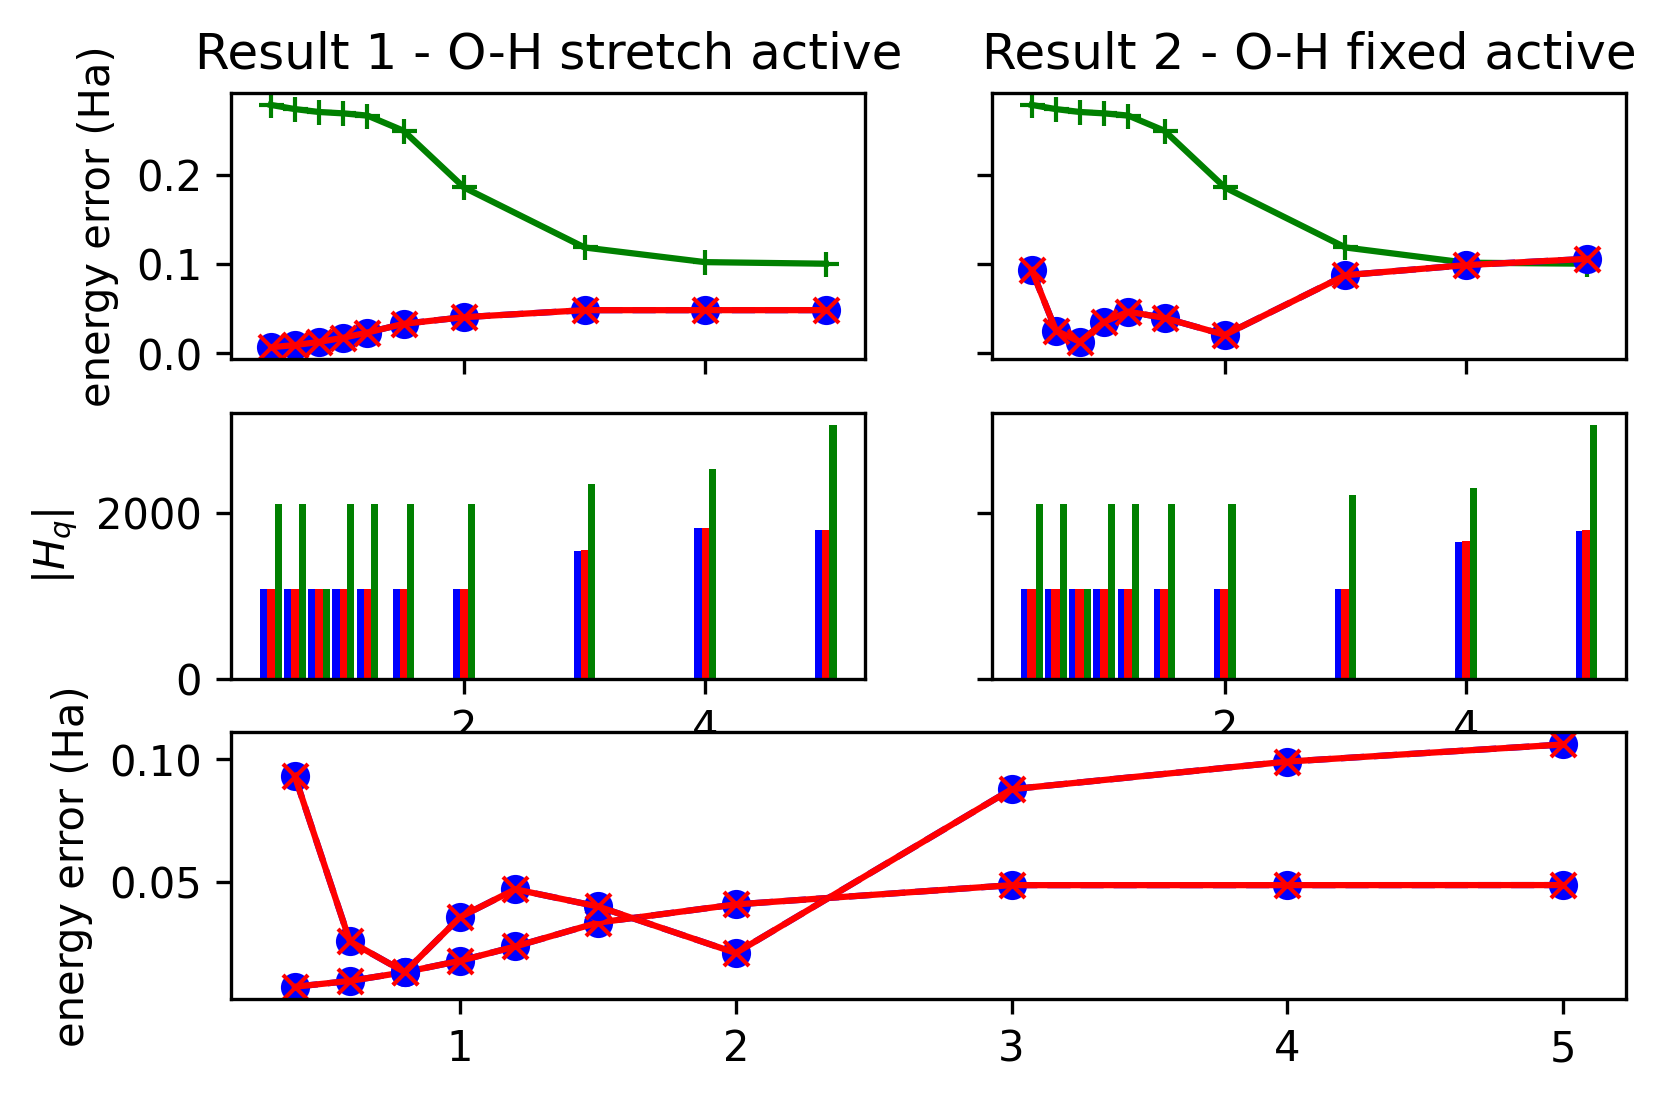

In [34]:
fig = plt.figure(dpi=300)

gs = fig.add_gridspec(3,2)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[2,:]) # goes over both columns!

# For first result
ax1.plot(R_list,abs(np.array(global_dft_list) - np.array(global_fci_list)), label='global DFT', color='g', marker='+')
ax1.plot(R_list,abs(np.array(huz_H_diag_list) - np.array(global_fci_list)), label='huz emb', linestyle='dashed', marker='o', color='b')
ax1.plot(R_list,abs(np.array(mu_H_diag_list) - np.array(global_fci_list)), label='mu emb', linestyle='-', marker='x', color='r')
ax1.set_ylabel('energy error (Ha)')
ax1.set_title("Result 1 - O-H stretch active")

# First result - number of terms
ax3.bar(np.array(R_list)-0.06, huz_qubit_H_length_list, width=0.06, color='b', align='center')
ax3.bar(R_list, mu_qubit_H_length_list, width=0.06, color='r', align='center')
ax3.bar(np.array(R_list)+0.06, global_qubit_H_length_list, width=0.06, color='g', align='center')
ax3.set_ylabel(r'$|H_{q}|$')
ax3.set_xlabel(r'Bond length ($\AA$)')
# axis[1, 0].set_title("Cosine Function")

# # 2nd result
ax2.plot(R_list,abs(np.array(global_dft_list2) - np.array(global_fci_list2)), label='global DFT', color='g', marker='+')
ax2.plot(R_list,abs(np.array(huz_H_diag_list2) - np.array(global_fci_list2)), label='Huz emb', linestyle='dashed', marker='o', color='b')
ax2.plot(R_list,abs(np.array(mu_H_diag_list2) - np.array(global_fci_list2)), label='Mu emb', linestyle='-', marker='x', color='r')
ax2.set_title("Result 2 - O-H fixed active")
  
# 2nd result - number of terms
ax4.bar(np.array(R_list)-0.06, huz_qubit_H_length_list2, width=0.06, color='b', align='center')
ax4.bar(R_list, mu_qubit_H_length_list2, width=0.075, color='r', align='center')
ax4.bar(np.array(R_list)+0.06, global_qubit_H_length_list2, width=0.06, color='g', align='center')
ax4.set_xlabel(r'Bond length ($\AA$)')

# shared y axis
ax1.get_shared_y_axes().join(ax1, ax2)
ax3.get_shared_y_axes().join(ax3, ax4)

# shared x axis
ax1.get_shared_x_axes().join(ax1, ax3)
ax2.get_shared_x_axes().join(ax2, ax4)


# remove rightmost y labels
ax2.set_yticklabels([])
ax4.set_yticklabels([])

# remove rightmost x labels
ax1.set_xticklabels([])
ax2.set_xticklabels([])

ax5.plot(R_list,abs(np.array(huz_H_diag_list) - np.array(global_fci_list)), label='huz emb', linestyle='dashed', marker='o', color='b')
ax5.plot(R_list,abs(np.array(mu_H_diag_list) - np.array(global_fci_list)), label='mu emb', linestyle='-', marker='x', color='r')
ax5.plot(R_list,abs(np.array(huz_H_diag_list2) - np.array(global_fci_list2)), label='Huz emb', linestyle='dashed', marker='o', color='b')
ax5.plot(R_list,abs(np.array(mu_H_diag_list2) - np.array(global_fci_list2)), label='Mu emb', linestyle='-', marker='x', color='r')

# ax5.plot(R_list,abs(np.array(global_dft_list2) - np.array(global_fci_list2)), label='global DFT', color='g', marker='+')
# ax5.plot(R_list,abs(np.array(global_dft_list) - np.array(global_fci_list)), label='global DFT', color='r', marker='x', linestyle='--')

ax5.set_ylabel('energy error (Ha)')

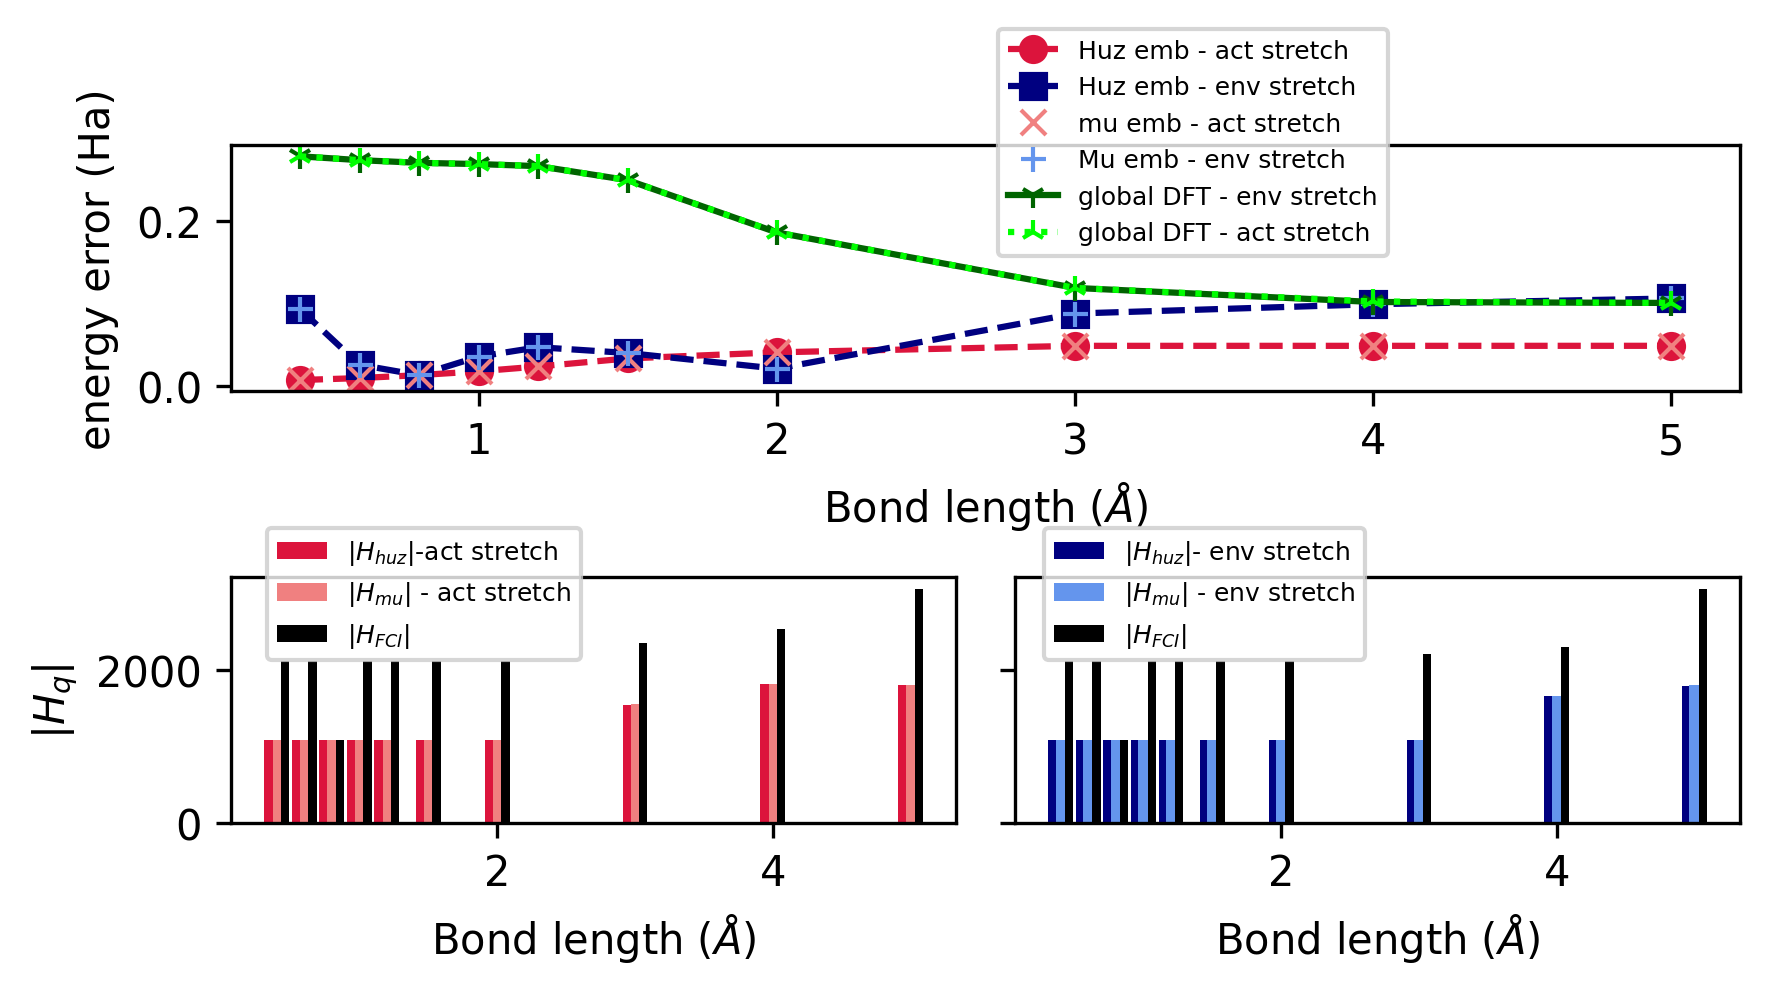

In [35]:
fig = plt.figure(dpi=300)

gs = fig.add_gridspec(3,2)

ax1 = fig.add_subplot(gs[0,:])# goes over both columns!
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[1,1])


ax1.plot(R_list,abs(np.array(huz_H_diag_list) - np.array(global_fci_list)), label='Huz emb - act stretch', marker='o',
         color='crimson', linestyle='dashed')
ax1.plot(R_list,abs(np.array(huz_H_diag_list2) - np.array(global_fci_list2)), label='Huz emb - env stretch', marker='s', 
         color='navy', linestyle='dashed')
ax1.plot(R_list,abs(np.array(mu_H_diag_list) - np.array(global_fci_list)), label='mu emb - act stretch', marker='x', 
         color='lightcoral',linestyle='')
ax1.plot(R_list,abs(np.array(mu_H_diag_list2) - np.array(global_fci_list2)), label='Mu emb - env stretch', marker='+', 
         color='cornflowerblue', linestyle='')

ax1.plot(R_list,abs(np.array(global_dft_list2) - np.array(global_fci_list2)), label='global DFT - env stretch', 
         color='darkgreen', marker='1')
ax1.plot(R_list,abs(np.array(global_dft_list) - np.array(global_fci_list)), label='global DFT - act stretch', 
         color='lime', marker='2', linestyle='dotted')


# ax1.legend(loc="upper right", fontsize =5)

ax1.set_ylabel('energy error (Ha)')
ax1.set_xlabel(r'Bond length ($\AA$)')


# First result - number of terms
ax2.bar(np.array(R_list)-0.06, huz_qubit_H_length_list, width=0.06, color='crimson', align='center', label='$|H_{huz}|$-act stretch')
ax2.bar(R_list, mu_qubit_H_length_list, width=0.06, color='lightcoral', align='center', label='$|H_{mu}|$ - act stretch')
ax2.bar(np.array(R_list)+0.06, global_qubit_H_length_list, width=0.06, color='k', align='center', label='$|H_{FCI}|$')
ax2.set_ylabel(r'$|H_{q}|$')
ax2.set_xlabel(r'Bond length ($\AA$)')
# axis[1, 0].set_title("Cosine Function")
  
# 2nd result - number of terms
ax3.bar(np.array(R_list)-0.06, huz_qubit_H_length_list2, width=0.06, color='navy', align='center', label='$|H_{huz}|$- env stretch')
ax3.bar(R_list, mu_qubit_H_length_list2, width=0.075, color='cornflowerblue', align='center', label='$|H_{mu}|$ - env stretch')
ax3.bar(np.array(R_list)+0.06, global_qubit_H_length_list2, width=0.06, color='k', align='center', label='$|H_{FCI}|$')
ax3.set_xlabel(r'Bond length ($\AA$)')

# shared y axis
ax2.get_shared_y_axes().join(ax2, ax3)

# remove rightmost y labels
ax3.set_yticklabels([])

plt.tight_layout()
ax1.legend(bbox_to_anchor=(0.5, 0.5, 0.5, 0.5), fontsize=6)
ax2.legend(bbox_to_anchor=(0.0, 0.75, 0.5, 0.5), fontsize=6)
ax3.legend(bbox_to_anchor=(0.0, 0.75, 0.5, 0.5), fontsize=6)

fig.savefig('water_correlated_results_new.png', bbox_inches = 'tight')
plt.show()


https://www.ucl.ac.uk/cam/brand/guidelines/colour

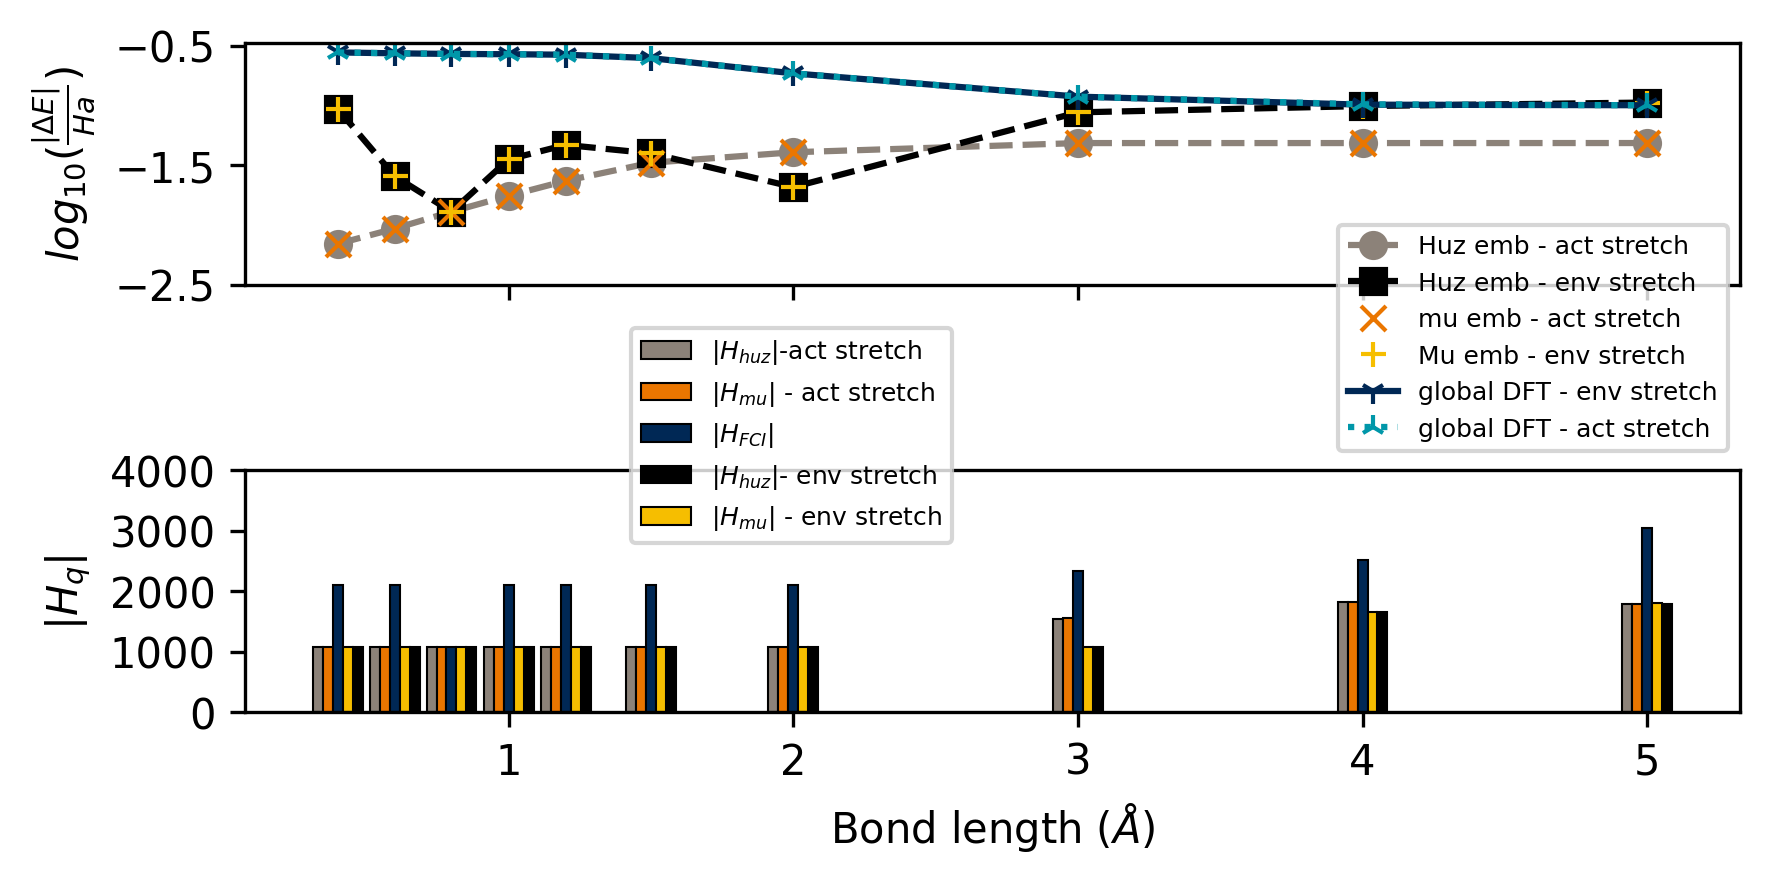

In [22]:
fig = plt.figure(dpi=300)

gs = fig.add_gridspec(3,2)

ax1 = fig.add_subplot(gs[0,:])# goes over both columns!
ax2 = fig.add_subplot(gs[1,:])
# ax3 = fig.add_subplot(gs[1,1])

# colour_stone = '#C0BDB0' #'#D6D2C4'
# colour_dark_brown = '#4E3629'

# colour_stone = '#500778' 
# colour_dark_brown = '#AC145A'

colour_stone = '#8C8279' 
colour_dark_brown = 'k'#'#47423e'

colour_midblue = '#002855'
colour_brightblue = '#0097A9'

colour_orange = '#EA7600'
colour_dark_yellow = '#F6BE00'

FCI_colour = '#002855'


ax1.plot(R_list,np.log10(abs(np.array(huz_H_diag_list) - np.array(global_fci_list))), label='Huz emb - act stretch', marker='o',
         color=colour_stone, linestyle='dashed')
ax1.plot(R_list,np.log10(abs(np.array(huz_H_diag_list2) - np.array(global_fci_list2))), label='Huz emb - env stretch', marker='s', 
         color=colour_dark_brown, linestyle='dashed')
ax1.plot(R_list,np.log10(abs(np.array(mu_H_diag_list) - np.array(global_fci_list))), label='mu emb - act stretch', marker='x', 
         color=colour_orange,linestyle='')
ax1.plot(R_list, np.log10(abs(np.array(mu_H_diag_list2) - np.array(global_fci_list2))), label='Mu emb - env stretch', marker='+', 
         color=colour_dark_yellow, linestyle='')

ax1.plot(R_list,np.log10(abs(np.array(global_dft_list2) - np.array(global_fci_list2))), label='global DFT - env stretch', 
         color=colour_midblue, marker='1')
ax1.plot(R_list,np.log10(abs(np.array(global_dft_list) - np.array(global_fci_list))), label='global DFT - act stretch', 
         color=colour_brightblue, marker='2', linestyle='dotted')


# ax1.legend(loc="upper right", fontsize =5)

# ax1.set_ylabel('energy error (Ha)')
ax1.set_ylabel(r'$log_{10}(\frac{|\Delta E|}{Ha})$')
# ax1.set_xlabel(r'Bond length ($\AA$)')
ax1.set_xticklabels([])


# First result - number of terms
wid = 0.035

ax2.bar(np.array(R_list)-2*wid, huz_qubit_H_length_list, width=wid, color=colour_stone, align='center', label='$|H_{huz}|$-act stretch', edgecolor='k', linewidth=0.5)
ax2.bar(np.array(R_list)-wid, mu_qubit_H_length_list, width=wid, color=colour_orange, align='center', label='$|H_{mu}|$ - act stretch', edgecolor='k', linewidth=0.5)
ax2.bar(np.array(R_list), global_qubit_H_length_list, width=wid, color=FCI_colour, align='center', label='$|H_{FCI}|$', edgecolor='k', linewidth=0.5)
ax2.set_ylabel(r'$|H_{q}|$')
ax2.set_xlabel(r'Bond length ($\AA$)')

ax2.bar(np.array(R_list)+2*wid, huz_qubit_H_length_list2, width=wid, color=colour_dark_brown, align='center', label='$|H_{huz}|$- env stretch', edgecolor='k', linewidth=0.5)
ax2.bar(np.array(R_list)+wid, mu_qubit_H_length_list2, width=wid, color=colour_dark_yellow, align='center', label='$|H_{mu}|$ - env stretch', edgecolor='k', linewidth=0.5)
ax2.set_xlabel(r'Bond length ($\AA$)')

# shared x axis
ax1.get_shared_x_axes().join(ax1, ax2)

# set axis limits
# ax1.yaxis.set_ticks(np.arange(0, 0.4, 0.1))
ax1.yaxis.set_ticks(np.arange(-2.5, 0, 1))
ax2.yaxis.set_ticks(np.arange(0, 5000, 1000))

plt.tight_layout()
# ax1.legend(bbox_to_anchor=(0.7, 0.5, 0.5, 0.5), fontsize=6)
ax1.legend(bbox_to_anchor=(0.5, -0.2, 0.5, 0.5), fontsize=6)
ax2.legend(bbox_to_anchor=(0.25, 0.65, 0.5, 0.5), fontsize=6)

fig.savefig('water_correlated_results_SPADE.png', bbox_inches = 'tight')
plt.show()


In [63]:
np.log10(2)

0.3010299956639812

In [24]:
df

,global DFT,global FCI,huz emb FCI,mu emb FCI,global H,huz H emb,mu H emb,global n qubits,huz n qubits,mu n qubits,N active MOs
0,-73.259936,-72.981056,-72.988008,-72.988009,2110,1079,1079,14,12,12,4
1,-74.773419,-74.499220,-74.508545,-74.508545,2110,1079,1079,14,12,12,4
2,-75.122053,-74.851089,-74.864002,-74.864002,1086,1079,1079,14,12,12,4
3,-75.170068,-74.900658,-74.918225,-74.918226,2110,1079,1079,14,12,12,4
4,-75.134418,-74.867498,-74.890912,-74.890913,2110,1079,1079,14,12,12,4
5,-75.057384,-74.807539,-74.840739,-74.840739,2110,1079,1079,14,12,12,4
6,-74.962535,-74.776263,-74.816902,-74.816902,2110,1079,1079,14,12,12,4
7,-74.890579,-74.771692,-74.820213,-74.820213,2342,1543,1551,14,12,12,4
8,-74.874152,-74.771719,-74.820244,-74.820244,2526,1819,1819,14,12,12,4
9,-74.872382,-74.771718,-74.820270,-74.820271,3054,1795,1795,14,12,12,4


In [28]:


R_list =  [0.4, 0.6, 0.7989538439284714, 1, 1.2, 1.5, 2, 3, 4, 5]

error_DFT = abs(np.array(global_dft_list) - np.array(global_fci_list))
error_HUZ = abs(np.array(huz_H_diag_list) - np.array(global_fci_list))
error_MU = abs(np.array(mu_H_diag_list) - np.array(global_fci_list))



In [30]:
plot_data_1 = {
    'OH length': R_list,
    'error DFT': error_DFT, 
    'error HUZ': error_HUZ,
    'error mu': error_MU,
    
    'Hfull': global_qubit_H_length_list,
    'Hhuz': huz_qubit_H_length_list,
    'Hmu': mu_qubit_H_length_list,
    
    'global n qubits': global_qubit_H_nqubits,
    'huz n qubits': huz_H_nqubits,
    'mu n qubits': mu_H_nqubits,
    'N active MOs': N_active_MOs,
}

df_data1= pd.DataFrame(data=plot_data_1)
df_data1

,OH length,error DFT,error HUZ,error mu,Hfull,Hhuz,Hmu,global n qubits,huz n qubits,mu n qubits,N active MOs
0,0.400000,0.278880,0.006952,0.006953,2110,1079,1079,14,12,12,4
1,0.600000,0.274200,0.009325,0.009326,2110,1079,1079,14,12,12,4
2,0.798954,0.270965,0.012913,0.012914,1086,1079,1079,14,12,12,4
3,1.000000,0.269410,0.017567,0.017568,2110,1079,1079,14,12,12,4
4,1.200000,0.266920,0.023415,0.023415,2110,1079,1079,14,12,12,4
5,1.500000,0.249844,0.033200,0.033200,2110,1079,1079,14,12,12,4
6,2.000000,0.186272,0.040638,0.040639,2110,1079,1079,14,12,12,4
7,3.000000,0.118887,0.048521,0.048522,2342,1543,1551,14,12,12,4
8,4.000000,0.102433,0.048525,0.048525,2526,1819,1819,14,12,12,4
9,5.000000,0.100664,0.048552,0.048553,3054,1795,1795,14,12,12,4


In [40]:
print(df_data1.to_latex(index=False))

\begin{tabular}{rrrrrrrrrrr}
\toprule
 OH length &  error DFT &  error HUZ &  error mu &  Hfull &  Hhuz &  Hmu &  global n qubits &  huz n qubits &  mu n qubits &  N active MOs \\
\midrule
  0.400000 &   0.278880 &   0.006952 &  0.006953 &   2110 &  1079 & 1079 &               14 &            12 &           12 &             4 \\
  0.600000 &   0.274200 &   0.009325 &  0.009326 &   2110 &  1079 & 1079 &               14 &            12 &           12 &             4 \\
  0.798954 &   0.270965 &   0.012913 &  0.012914 &   1086 &  1079 & 1079 &               14 &            12 &           12 &             4 \\
  1.000000 &   0.269410 &   0.017567 &  0.017568 &   2110 &  1079 & 1079 &               14 &            12 &           12 &             4 \\
  1.200000 &   0.266920 &   0.023415 &  0.023415 &   2110 &  1079 & 1079 &               14 &            12 &           12 &             4 \\
  1.500000 &   0.249844 &   0.033200 &  0.033200 &   2110 &  1079 & 1079 &               14 &        

In [34]:
error_DFT2 = abs(np.array(global_dft_list2) - np.array(global_fci_list2))
error_HUZ2 = abs(np.array(huz_H_diag_list2) - np.array(global_fci_list2))
error_MU2 = abs(np.array(mu_H_diag_list2) - np.array(global_fci_list2))


plot_data_2 = {
    'OH length': R_list,
    'error DFT': error_DFT2, 
    'error HUZ': error_HUZ2,
    'error mu': error_MU2,
    
    'Hfull': global_qubit_H_length_list2,
    'Hhuz': huz_qubit_H_length_list2,
    'Hmu': mu_qubit_H_length_list2,
    
    'global n qubits': global_qubit_H_nqubits2,
    'huz n qubits': huz_H_nqubits2,
    'mu n qubits': mu_H_nqubits2,
    'N active MOs': N_active_MOs2,
}

df_data2= pd.DataFrame(data=plot_data_2)
df_data2

,OH length,error DFT,error HUZ,error mu,Hfull,Hhuz,Hmu,global n qubits,huz n qubits,mu n qubits,N active MOs
0,0.400000,0.278880,0.093234,0.093229,2110,1079,1079,14,12,12,4
1,0.600000,0.274200,0.025531,0.025529,2110,1079,1079,14,12,12,4
2,0.798954,0.270965,0.012913,0.012914,1086,1079,1079,14,12,12,4
3,1.000000,0.269410,0.035443,0.035443,2110,1079,1079,14,12,12,4
4,1.200000,0.266920,0.046838,0.046838,2110,1079,1079,14,12,12,4
5,1.500000,0.249844,0.039789,0.039789,2110,1079,1079,14,12,12,4
6,2.000000,0.186272,0.020758,0.020758,2110,1079,1079,14,12,12,4
7,3.000000,0.118887,0.087767,0.087767,2210,1079,1083,14,12,12,4
8,4.000000,0.101794,0.099082,0.099082,2294,1655,1663,14,12,12,4
9,5.000000,0.100663,0.106092,0.106092,3054,1783,1799,14,12,12,4


In [41]:
print(df_data2.to_latex(index=False))

\begin{tabular}{rrrrrrrrrrr}
\toprule
 OH length &  error DFT &  error HUZ &  error mu &  Hfull &  Hhuz &  Hmu &  global n qubits &  huz n qubits &  mu n qubits &  N active MOs \\
\midrule
  0.400000 &   0.278880 &   0.093234 &  0.093229 &   2110 &  1079 & 1079 &               14 &            12 &           12 &             4 \\
  0.600000 &   0.274200 &   0.025531 &  0.025529 &   2110 &  1079 & 1079 &               14 &            12 &           12 &             4 \\
  0.798954 &   0.270965 &   0.012913 &  0.012914 &   1086 &  1079 & 1079 &               14 &            12 &           12 &             4 \\
  1.000000 &   0.269410 &   0.035443 &  0.035443 &   2110 &  1079 & 1079 &               14 &            12 &           12 &             4 \\
  1.200000 &   0.266920 &   0.046838 &  0.046838 &   2110 &  1079 & 1079 &               14 &            12 &           12 &             4 \\
  1.500000 &   0.249844 &   0.039789 &  0.039789 &   2110 &  1079 & 1079 &               14 &        